# Testing validation and test set relation

In [1]:
# import
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
# configs.
%matplotlib inline

pd.set_option("display.max_columns", 500)

path = "../../../data/split"
random_state = 42

In [3]:
os.listdir(path)

['1.1 - df_test 04-19to04-19.feather',
 '1.1 - df_train.feather',
 '1.1 - df_val 01-19to03-19.feather',
 '1.1 - df_test 04-19to05-19.feather',
 '1.1 - df_train only 2018 without nulls.feather',
 '1.1 - df_train with nan.feather']

# Creating 5 models to evaluate

**Models:**<br>
1) full Dataset, class_weight=balanced<br>
2) last 6 months, class_weight=balanced_subsample<br>
3) last month<br>
4) last 2 weeks<br>
5) full dataset overffiting<br>

## Reading training set

In [4]:
df_train = pd.read_feather(os.path.join(path, "1.1 - df_train with nan.feather"))
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1055951 entries, 0 to 1055950
Columns: 152 entries, NUM_SECU_EXPED to FECHA_SINI_Elapsed
dtypes: bool(2), datetime64[ns](1), float64(75), int16(12), int32(2), int64(2), int8(58)
memory usage: 721.0 MB


/home/voolkia/anaconda3/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [5]:
# df_train.select_dtypes("datetime64").columns
df_train.head()

,NUM_SECU_EXPED,cond_04,cond_05,cond_06,cond_09,cond_11,cond_12,cond_32,cond_37,cond_C1,cond_C10,cond_C11,cond_C12,cond_C13,cond_C14,cond_C15,cond_C16,cond_C17,cond_C18,cond_C19,cond_C2,cond_C20,cond_C21,cond_C3,cond_C4,cond_C5,cond_C6,cond_C7,cond_C8,cond_C9,USR_ACT,total_condicion,es_gte_5,COD_FRAUDE,COD_RAMO,EXISTE_FRAUDE,EXISTE_INHABILITAR,EXISTE_INVEST,preg_1,preg_2,preg_3,preg_4,preg_5,preg_6,preg_7,preg_8,preg_9,preg_10,preg_11,preg_12,preg_15,preg_16,preg_18,preg_19,preg_22,preg_24,preg_27,preg_28,preg_30,preg_31,preg_32,preg_33,preg_34,preg_36,preg_37,CATASTROFICO,CERRADURA_BAUL,CERRADURA_DERECHA,CERRADURA_IZQUIERDA,CODIGO_BAJA,CODIGO_CARATULA,CODIGO_REAPERTURA,CODIGO_VEHICULO,COD_ACT_BENEF,COD_CAUSA_SINI,COD_POST_OCURRENCIA,COD_POST_POLIZA,COD_POST_TERC,COD_RIES_sini,CONDICION_ROBO_EXP50,DANOS_MATERIALES,DESCRIPCION_TIPO,DESCRIPCION_VEHICULO,ESTADO_CIVIL,ESTADO_CIVIL_TERC,ESTAD_VEH_ASEG,FALTANTE,FECHA_SINI,MCA_COASEG,MCA_JUICIO,MCA_VIP,METRO,NUM_SECU_POL,OCUPACION_ASEG,SEXO,SEXO_TERC,TELEFONO_TERC,TIPO,TIPO_EXPED,TIPO_LESION,TIPO_LESION_MAXIMA,TIPO_SINIESTRO,USO,dias_entre_denu_y_sini,dist_fformal_fsini,dist_fformal_fdenu,existe_FECHA_FORMAL,CANT_RENOVACION,CAPITAL_ACCESORIOS,CAPITAL_ASEGURADO_COTIZACION,CAPITAL_VEHICULO,COD_COBRO,COD_COBRO_ANTERIOR,COD_POSTAL,COD_PROD,COD_ZONA_CASCO,COD_ZONA_RC,COD_ZONA_ROBO,CONV_COMISIONARIO,CIF_ID,MCA_AGRAVANTE,MCA_EMPLEADO,MCA_MOVIMIENTO,MCA_POLIZA_VIP,NEGOCIO,PRENDARIO,SEGMENTO,cambio_cobro,ANTIG_pol,COD_EST_CIVIL,TIPO_ACTIVIDAD,CLIENTE,CODIGO_NACION,DATECO_TIPO_ACTIVIDAD,DOMICILIO_CODIGO_POSTAL,HABILITADO,FECHA_SINI_Year,FECHA_SINI_Month,FECHA_SINI_Week,FECHA_SINI_Day,FECHA_SINI_Dayofweek,FECHA_SINI_Dayofyear,FECHA_SINI_Is_month_end,FECHA_SINI_Is_month_start,FECHA_SINI_Is_quarter_end,FECHA_SINI_Is_quarter_start,FECHA_SINI_Is_year_end,FECHA_SINI_Is_year_start,FECHA_SINI_Hour,FECHA_SINI_Minute,FECHA_SINI_Second,FECHA_SINI_Elapsed
0,516359994,0.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,1.0,3.0,949,4.0,False,-1.0,-1.0,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1,-1,-1,-1,-1.0,-1,NaT,-1,-1,-1,-1,-1.0,-1.0,-1,-1,-1,-1.0,-1,-1,-1,-1,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1,-1,-1,-1,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1,-1,-1,-1,-1,-1,-1,-1,-1.0,-1,-1,-1,-1,-1,-1.0,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-9223372037
1,1762619999,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,254,0.0,False,-1.0,-1.0,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1,-1,-1,-1,-1.0,-1,NaT,-1,-1,-1,-1,-1.0,-1.0,-1,-1,-1,-1.0,-1,-1,-1,-1,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1,-1,-1,-1,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1,-1,-1,-1,-1,-1,-1,-1,-1.0,-1,-1,-1,-1,-1,-1.0,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-9223372037
2,4768809999,0.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,0.0,3.0,21,3.0,False,-1.0,-1.0,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1,-1,-1,-1,-1.0,-1,NaT,-1,-1,-1,-1,-1.0,-1.0,-1,-1,-1,-1.0,-1,-1,-1,-1,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1,-1,-1,-1,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1,-1,-1,-1,-1,-1,-1,-1,-1.0,-1,-1,-1,-1,-1,-1.0,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-9223372037
3,6444209999,0.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,0.0,3.0,612,3.0,False,-1.0,-1.0,False,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,

In [8]:
# cols to drop
to_drop = ["COD_FRAUDE", "EXISTE_FRAUDE", "FECHA_SINI", "EXISTE_INHABILITAR", "EXISTE_INVEST"]

X_train = df_train.drop(columns=to_drop)
y_train = df_train['EXISTE_FRAUDE']

## Reading validation set

In [7]:
df_val = pd.read_feather(os.path.join(path, "1.1 - df_val 01-19to03-19.feather"))
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107264 entries, 0 to 107263
Columns: 152 entries, NUM_SECU_EXPED to FECHA_SINI_Elapsed
dtypes: bool(2), datetime64[ns](1), float64(75), int16(12), int32(2), int64(2), int8(58)
memory usage: 73.2 MB


/home/voolkia/anaconda3/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [11]:
print(df_val["FECHA_SINI"].min(), df_val["FECHA_SINI"].max())
# df_val = df_val[df_val["FECHA_SINI"] >= "2019-02-01"]
# print(df_val["FECHA_SINI"].min(), df_val["FECHA_SINI"].max())

2019-01-01 00:00:00 2019-03-31 00:00:00


In [12]:
# add to drop latter
X_val = df_val.drop(columns=to_drop)
y_val = df_val['EXISTE_FRAUDE']

## Reading test set

In [13]:
df_test = pd.read_feather(os.path.join(path, "1.1 - df_test 04-19to04-19.feather"))
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34658 entries, 0 to 34657
Columns: 152 entries, NUM_SECU_EXPED to FECHA_SINI_Elapsed
dtypes: bool(2), datetime64[ns](1), float64(75), int16(12), int32(2), int64(2), int8(58)
memory usage: 23.7 MB


/home/voolkia/anaconda3/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [14]:
# add to drop latter
X_test = df_test.drop(columns=to_drop)
y_test = df_test['EXISTE_FRAUDE']

## Model 1 - train from full dataset, class_weight=balanced

In [12]:
# ??RandomForestClassifier

In [15]:
rf1 = RandomForestClassifier(n_estimators=50, n_jobs=-1, min_samples_leaf=3, class_weight="balanced", random_state=random_state)
rf1.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=3,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [16]:
X_val.head()

,NUM_SECU_EXPED,cond_04,cond_05,cond_06,cond_09,cond_11,cond_12,cond_32,cond_37,cond_C1,cond_C10,cond_C11,cond_C12,cond_C13,cond_C14,cond_C15,cond_C16,cond_C17,cond_C18,cond_C19,cond_C2,cond_C20,cond_C21,cond_C3,cond_C4,cond_C5,cond_C6,cond_C7,cond_C8,cond_C9,USR_ACT,total_condicion,es_gte_5,COD_RAMO,preg_1,preg_2,preg_3,preg_4,preg_5,preg_6,preg_7,preg_8,preg_9,preg_10,preg_11,preg_12,preg_15,preg_16,preg_18,preg_19,preg_22,preg_24,preg_27,preg_28,preg_30,preg_31,preg_32,preg_33,preg_34,preg_36,preg_37,CATASTROFICO,CERRADURA_BAUL,CERRADURA_DERECHA,CERRADURA_IZQUIERDA,CODIGO_BAJA,CODIGO_CARATULA,CODIGO_REAPERTURA,CODIGO_VEHICULO,COD_ACT_BENEF,COD_CAUSA_SINI,COD_POST_OCURRENCIA,COD_POST_POLIZA,COD_POST_TERC,COD_RIES_sini,CONDICION_ROBO_EXP50,DANOS_MATERIALES,DESCRIPCION_TIPO,DESCRIPCION_VEHICULO,ESTADO_CIVIL,ESTADO_CIVIL_TERC,ESTAD_VEH_ASEG,FALTANTE,MCA_COASEG,MCA_JUICIO,MCA_VIP,METRO,NUM_SECU_POL,OCUPACION_ASEG,SEXO,SEXO_TERC,TELEFONO_TERC,TIPO,TIPO_EXPED,TIPO_LESION,TIPO_LESION_MAXIMA,TIPO_SINIESTRO,USO,dias_entre_denu_y_sini,dist_fformal_fsini,dist_fformal_fdenu,existe_FECHA_FORMAL,CANT_RENOVACION,CAPITAL_ACCESORIOS,CAPITAL_ASEGURADO_COTIZACION,CAPITAL_VEHICULO,COD_COBRO,COD_COBRO_ANTERIOR,COD_POSTAL,COD_PROD,COD_ZONA_CASCO,COD_ZONA_RC,COD_ZONA_ROBO,CONV_COMISIONARIO,CIF_ID,MCA_AGRAVANTE,MCA_EMPLEADO,MCA_MOVIMIENTO,MCA_POLIZA_VIP,NEGOCIO,PRENDARIO,SEGMENTO,cambio_cobro,ANTIG_pol,COD_EST_CIVIL,TIPO_ACTIVIDAD,CLIENTE,CODIGO_NACION,DATECO_TIPO_ACTIVIDAD,DOMICILIO_CODIGO_POSTAL,HABILITADO,FECHA_SINI_Year,FECHA_SINI_Month,FECHA_SINI_Week,FECHA_SINI_Day,FECHA_SINI_Dayofweek,FECHA_SINI_Dayofyear,FECHA_SINI_Is_month_end,FECHA_SINI_Is_month_start,FECHA_SINI_Is_quarter_end,FECHA_SINI_Is_quarter_start,FECHA_SINI_Is_year_end,FECHA_SINI_Is_year_start,FECHA_SINI_Hour,FECHA_SINI_Minute,FECHA_SINI_Second,FECHA_SINI_Elapsed
0,1905896179999,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,993,0.0,False,-1.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,0,-1.0,-1.0,-1.0,14730.0,3.0,226.0,1437000.0,1437000.0,-1.0,1.0,-1.0,0,3,6363,6,-1,3.0,1,0,-1,1,1,1.883541e+12,5.0,0,-1,-1,3.0,3,-1,-1,7,1.0,0.0,-1.0,-1.0,0,2.0,8,1188,2076,0,0,1437000.0,72476.0,1.0,1.0,3.0,3,-1.0,0,0,-1,1,21,0,0,0,30.0,-1,-1,-1,-1,-1,-1.0,-1,2019.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1546300800
1,1905896259999,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,1075,0.0,False,-1.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,-1,-1,-1,-1.0,-1.0,-1.0,2017.0,-1.0,501.0,1173000.0,1414000.0,-1.0,1.0,-1.0,0,3,968,0,-1,3.0,1,0,-1,1,1,1.884784e+12,5.0,1,1,-1,3.0,2,-1,-1,1,1.0,0.0,-1.0,-1.0,0,28.0,63,964,1472,5,5,1414000.0,5660.0,1.0,1.0,3.0,107,-1.0,0,0,-1,1,21,0,3,0,821.0,-1,-1,-1,-1,-1,-1.0,-1,2019.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1546300800
2,1905896279999,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,-1.0,0.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,993,0.0,False,8.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,0,-1.0,-1.0,-1.0,14255.0,26.0,209.0,5000050.0,5109001.0,-1.0,1.0,-1.0,0,3,6667,0,-1,5.0,1,0,-1,1,0,1.892197e+12,5.0,0,-1,-1,3.0,13,-1,-1,7,1.0,0.0,-1.0,-1.0,0,26.0,8,2195,4261,2,2,5109001.0,73338.0,1.0,4.0,3.0,14,-1.0,1,0,-1,1,47,1,-1,0,740.0,-1,-1,-1,-1,-1,-1.0,-1,2019.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1546300800
3,1905896299999,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,393,0.0,False,-1.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,0,-1.0,-1.0,-1.0,2605.0,26.0,501.0,8300001.0,8300001.0,-1.0,1.0,-1.0,0,3,995,6,-1,3.0,0,0,-1,1,0,1.874

In [17]:
X_test.head()

,NUM_SECU_EXPED,cond_04,cond_05,cond_06,cond_09,cond_11,cond_12,cond_32,cond_37,cond_C1,cond_C10,cond_C11,cond_C12,cond_C13,cond_C14,cond_C15,cond_C16,cond_C17,cond_C18,cond_C19,cond_C2,cond_C20,cond_C21,cond_C3,cond_C4,cond_C5,cond_C6,cond_C7,cond_C8,cond_C9,USR_ACT,total_condicion,es_gte_5,COD_RAMO,preg_1,preg_2,preg_3,preg_4,preg_5,preg_6,preg_7,preg_8,preg_9,preg_10,preg_11,preg_12,preg_15,preg_16,preg_18,preg_19,preg_22,preg_24,preg_27,preg_28,preg_30,preg_31,preg_32,preg_33,preg_34,preg_36,preg_37,CATASTROFICO,CERRADURA_BAUL,CERRADURA_DERECHA,CERRADURA_IZQUIERDA,CODIGO_BAJA,CODIGO_CARATULA,CODIGO_REAPERTURA,CODIGO_VEHICULO,COD_ACT_BENEF,COD_CAUSA_SINI,COD_POST_OCURRENCIA,COD_POST_POLIZA,COD_POST_TERC,COD_RIES_sini,CONDICION_ROBO_EXP50,DANOS_MATERIALES,DESCRIPCION_TIPO,DESCRIPCION_VEHICULO,ESTADO_CIVIL,ESTADO_CIVIL_TERC,ESTAD_VEH_ASEG,FALTANTE,MCA_COASEG,MCA_JUICIO,MCA_VIP,METRO,NUM_SECU_POL,OCUPACION_ASEG,SEXO,SEXO_TERC,TELEFONO_TERC,TIPO,TIPO_EXPED,TIPO_LESION,TIPO_LESION_MAXIMA,TIPO_SINIESTRO,USO,dias_entre_denu_y_sini,dist_fformal_fsini,dist_fformal_fdenu,existe_FECHA_FORMAL,CANT_RENOVACION,CAPITAL_ACCESORIOS,CAPITAL_ASEGURADO_COTIZACION,CAPITAL_VEHICULO,COD_COBRO,COD_COBRO_ANTERIOR,COD_POSTAL,COD_PROD,COD_ZONA_CASCO,COD_ZONA_RC,COD_ZONA_ROBO,CONV_COMISIONARIO,CIF_ID,MCA_AGRAVANTE,MCA_EMPLEADO,MCA_MOVIMIENTO,MCA_POLIZA_VIP,NEGOCIO,PRENDARIO,SEGMENTO,cambio_cobro,ANTIG_pol,COD_EST_CIVIL,TIPO_ACTIVIDAD,CLIENTE,CODIGO_NACION,DATECO_TIPO_ACTIVIDAD,DOMICILIO_CODIGO_POSTAL,HABILITADO,FECHA_SINI_Year,FECHA_SINI_Month,FECHA_SINI_Week,FECHA_SINI_Day,FECHA_SINI_Dayofweek,FECHA_SINI_Dayofyear,FECHA_SINI_Is_month_end,FECHA_SINI_Is_month_start,FECHA_SINI_Is_quarter_end,FECHA_SINI_Is_quarter_start,FECHA_SINI_Is_year_end,FECHA_SINI_Is_year_start,FECHA_SINI_Hour,FECHA_SINI_Minute,FECHA_SINI_Second,FECHA_SINI_Elapsed
0,1939210429999,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,405,0.0,False,-1.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,0,-1.0,-1.0,-1.0,18380.0,3.0,226.0,1439000.0,1439000.0,-1.0,1.0,-1.0,0,3,7721,0,-1,5.0,1,0,-1,1,1,1.898594e+12,44.0,1,-1,-1,3.0,3,-1,-1,5,1.0,0.0,-1.0,-1.0,0,24.0,8,2293,4514,0,0,1439000.0,73747.0,1.0,1.0,3.0,23,-1.0,0,0,-1,1,21,0,0,0,699.0,-1,-1,-1,-1,-1,-1.0,-1,2019.0,4.0,14.0,1.0,0.0,91.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1554076800
1,1939210489999,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,993,0.0,False,-1.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,0,-1.0,-1.0,-1.0,6846.0,3.0,226.0,1708000.0,1684001.0,-1.0,1.0,-1.0,0,3,3091,0,-1,3.0,1,0,-1,1,1,1.911869e+12,5.0,1,-1,-1,3.0,3,-1,-1,5,1.0,0.0,-1.0,-1.0,0,41.0,8,1985,3913,0,0,1684001.0,5350.0,1.0,1.0,1.0,107,-1.0,0,0,-1,1,21,0,5,0,1216.0,-1,-1,-1,-1,-1,-1.0,-1,2019.0,4.0,14.0,1.0,0.0,91.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1554076800
2,1939210519999,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,0.0,0.0,1.0,0.0,-1.0,-1.0,-1.0,3.0,-1.0,-1.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,405,4.0,False,-1.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,4,-1,0,-1,-1,-1,-1,121,133,1,-1,1,-1,-1,-1,-1,0,-1,-1,-1,-1.0,-1.0,-1.0,2605.0,-1.0,202.0,1678002.0,1407000.0,-1.0,1.0,1.0,0,3,995,6,-1,3.0,1,0,-1,0,1,1.926715e+12,44.0,1,-1,-1,3.0,12,-1,-1,6,1.0,0.0,-1.0,-1.0,0,1.0,8,433,674,5,-1,1407000.0,73761.0,1.0,1.0,3.0,38,-1.0,0,0,0,0,43,0,5,0,0.0,-1,-1,-1,-1,-1,-1.0,-1,2019.0,4.0,14.0,1.0,0.0,91.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1554076800
3,1939210639999,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,405,0.0,False,-1.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,-1,-1,-1,-1.0,-1.0,-1.0,5611.0,-1.0,501.0,5178015.0,5178011.0,-1.0,1.0,-1.0,0,3,3038,6,-1,3.0,1,0,-1,1,0

In [18]:
y_val_1 = rf1.predict(X_val)
y_test_1 = rf1.predict(X_test)

In [19]:
f1_val_1 = f1_score(y_val, y_val_1)
f1_test_1 = f1_score(y_test, y_test_1)
print(f"val: {f1_val_1}, test: {f1_test_1}")

val: 0.7708533077660594, test: 0.6951871657754011


## Model 5 - train from full dataset overfit

In [20]:
rf5 = RandomForestClassifier(n_estimators=30, n_jobs=-1, min_samples_leaf=1, random_state=random_state)
rf5.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [21]:
y_val_5 = rf5.predict(X_val)
y_test_5 = rf5.predict(X_test)

In [22]:
f1_val_5 = f1_score(y_val, y_val_5)
f1_test_5 = f1_score(y_test, y_test_5)
print(f"val: {f1_val_5}, test: {f1_test_5}")

val: 0.692063492063492, test: 0.6477272727272727


## Model 2: last 6 months, class_weight=balanced_subsample

In [42]:
df_train["FECHA_SINI"].min(), df_train["FECHA_SINI"].max()

(Timestamp('2017-01-01 00:00:00'), Timestamp('2018-12-31 00:00:00'))

In [43]:
X_train = df_train[df_train["FECHA_SINI"] >= "2018-5-31"].drop(columns=to_drop)
y_train = df_train[df_train["FECHA_SINI"] >= "2018-5-31"]['EXISTE_FRAUDE']

In [44]:
y_train.sum() / len(y_train)

0.0038030596854126265

In [45]:
rf2 = RandomForestClassifier(n_estimators=30, n_jobs=-1, min_samples_leaf=3, class_weight="balanced_subsample", random_state=random_state)
rf2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=3,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [46]:
y_val_2 = rf2.predict(X_val)
y_test_2 = rf2.predict(X_test)

In [47]:
f1_val_2 = f1_score(y_val, y_val_2)
f1_test_2 = f1_score(y_test, y_test_2)
print(f"val: {f1_val_2}, test: {f1_test_2}")

val: 0.740814299900695, test: 0.6408839779005524


## Model 3: last month, class_weight=balanced_subsample

In [23]:
X_train = df_train[df_train["FECHA_SINI"] >= "2018-12-01"].drop(columns=to_drop)
y_train = df_train[df_train["FECHA_SINI"] >= "2018-12-01"]['EXISTE_FRAUDE']

In [24]:
y_train.sum() / len(y_train)

0.004591774094536525

In [25]:
rf3 = RandomForestClassifier(n_estimators=140, n_jobs=-1, min_samples_leaf=7, class_weight="balanced_subsample", random_state=random_state)
rf3.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=7,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=140, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [26]:
y_val_3 = rf3.predict(X_val)
y_test_3 = rf3.predict(X_test)

In [27]:
f1_val_3 = f1_score(y_val, y_val_3)
f1_test_3 = f1_score(y_test, y_test_3)
print(f"val: {f1_val_3}, test: {f1_test_3}")

val: 0.6738627602158828, test: 0.6229508196721312


## Model 4: last 2 weeks

In [28]:
X_train = df_train[df_train["FECHA_SINI"] >= "2018-12-15"].drop(columns=to_drop)
y_train = df_train[df_train["FECHA_SINI"] >= "2018-12-15"]['EXISTE_FRAUDE']

In [29]:
rf4 = RandomForestClassifier(n_estimators=223, n_jobs=-1, min_samples_leaf=3, class_weight="balanced_subsample", random_state=random_state)
rf4.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=3,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=223, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [30]:
y_val_4 = rf4.predict(X_val)
y_test_4 = rf4.predict(X_test)

In [31]:
f1_val_4 = f1_score(y_val, y_val_4)
f1_test_4 = f1_score(y_test, y_test_4)
print(f"val: {f1_val_4}, test: {f1_test_4}")

val: 0.7100712105798576, test: 0.631578947368421


## Model 6: random sample Training set

In [32]:
X_train = df_train.drop(columns=to_drop)
y_train = df_train['EXISTE_FRAUDE']

In [33]:
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.5, random_state=random_state)
train_index, test_index = sss.split(X_train, y_train)
train_index

(array([153737, 835098, 106687, ..., 375220, 119896, 971086]),
 array([282262, 657276,  17691, ..., 531971, 431165, 330210]))

In [34]:
X_train = X_train.iloc[train_index[0]]
y_train = y_train.iloc[train_index[0]]

In [35]:
rf6 = RandomForestClassifier(n_estimators=40, n_jobs=-1, min_samples_leaf=3, class_weight="balanced_subsample", random_state=random_state)
rf6.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=3,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=40, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [36]:
y_val_6 = rf6.predict(X_val)
y_test_6 = rf6.predict(X_test)

In [37]:
f1_val_6 = f1_score(y_val, y_val_6)
f1_test_6 = f1_score(y_test, y_test_6)
print(f"val: {f1_val_6}, test: {f1_test_6}")

val: 0.7721639656816015, test: 0.708994708994709


## plot result

In [56]:
val_res = [f1_val_1, f1_val_2, f1_val_3, f1_val_4, f1_val_5, f1_val_6]
test_res = [f1_test_1, f1_test_2, f1_test_3, f1_test_4, f1_test_5, f1_test_6]
for val, test in zip(val_res, test_res):
    print(f"{round(val,3)};{round(test,3)}")

0.771;0.695
0.741;0.641
0.674;0.623
0.71;0.632
0.692;0.648
0.772;0.709


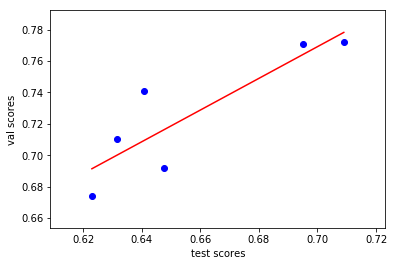

In [51]:
# val set last 1 month (March), full test set
x = np.linspace(min(test_res), max(test_res), 10)

# finding a linear relationship between the results.
m1, b1 = np.polyfit(test_res, val_res, 1)

f, ax = plt.subplots(1, 1)

ax.set_xlabel("test scores")
ax.set_ylabel("val scores")
ax.scatter(test_res, val_res, color="blue")
ax.plot(x, m1*x +b1, "-", color="red")

plt.show()

In [52]:
print(f"a: {m1}, b: {b1}")

a: 1.00911906799865, b: 0.06275170631672154


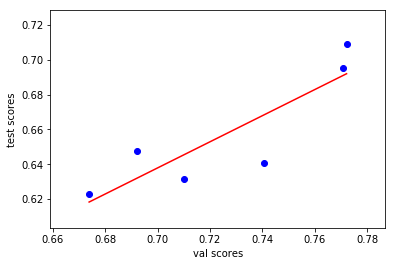

In [53]:
x = np.linspace(min(val_res), max(val_res), 10)

# finding a linear relationship between the results.
m1, b1 = np.polyfit(val_res, test_res, 1)

f, ax = plt.subplots(1, 1)

ax.set_xlabel("val scores")
ax.set_ylabel("test scores")
ax.scatter(val_res, test_res, color="blue")
ax.plot(x, m1*x +b1, "-", color="red")

plt.show()

In [54]:
print(f"a: {m1}, b: {b1}")

a: 0.7503603836698823, b: 0.11264665068244475


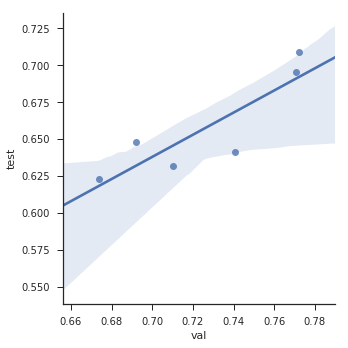

In [57]:
import seaborn as sns

res = pd.DataFrame({"val": val_res, "test": test_res})
sns.set(style="ticks")

sns.lmplot(x="val", y="test", data=res)